In [2]:
# Load libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn
import matplotlib.pyplot as plt

# Data exploration

In [3]:
# Load the data
# The data comes from data.world
# https://data.world/sdhilip/pizza-datasets
pizza = pd.read_csv('../raw_data/Pizza.csv')
pizza

brand     id   mois   prot    fat   ash  sodium   carb   cal
0       A  14069  27.82  21.43  44.87  5.11    1.77   0.77  4.93
1       A  14053  28.49  21.26  43.89  5.34    1.79   1.02  4.84
2       A  14025  28.35  19.99  45.78  5.08    1.63   0.80  4.95
3       A  14016  30.55  20.15  43.13  4.79    1.61   1.38  4.74
4       A  14005  30.49  21.28  41.65  4.82    1.64   1.76  4.67
..    ...    ...    ...    ...    ...   ...     ...    ...   ...
295     J  34044  44.91  11.07  17.00  2.49    0.66  25.36  2.91
296     J  24069  43.15  11.79  18.46  2.43    0.67  24.17  3.10
297     J  34039  44.55  11.01  16.03  2.43    0.64  25.98  2.92
298     J  14044  47.60  10.43  15.18  2.32    0.56  24.47  2.76
299     J  14045  46.84   9.91  15.50  2.27    0.57  25.48  2.81

[300 rows x 9 columns]

In [4]:
pizza.info()
# We see that there is enough data for the analysis
# rows > 6 variables*10 subjects

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   brand   300 non-null    object 
 1   id      300 non-null    int64  
 2   mois    300 non-null    float64
 3   prot    300 non-null    float64
 4   fat     300 non-null    float64
 5   ash     300 non-null    float64
 6   sodium  300 non-null    float64
 7   carb    300 non-null    float64
 8   cal     300 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.2+ KB


# Transform data

In [50]:
# Standardize the feature matrix
# for the data to have mean = 0 and variance = 1
print(pizza.loc[:,'mois':'carb'].shape) # Original shape
print(pizza.loc[:,'mois':'carb'].columns)
# We exclude calories because it might represent some of the other variables
features = StandardScaler().fit_transform(pizza.loc[:,'mois':'carb'])
features.shape

(300, 6)
Index(['mois', 'prot', 'fat', 'ash', 'sodium', 'carb'], dtype='object')


(300, 6)

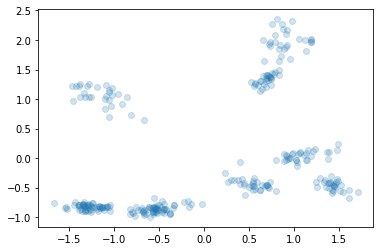

In [51]:
# Plot the transformed data for the first two columns
plt.scatter(features[:, 0], features[:, 1], alpha=0.2)

<AxesSubplot:>

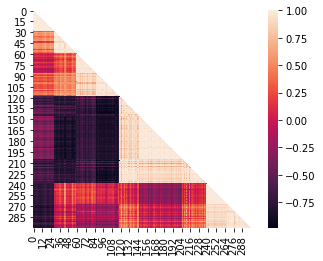

In [52]:
# Check the correlations between standardized entries
# Mask redundant info (upper diagonal correlations)
corr = np.corrcoef(features)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr, mask=mask, square=True)

We see that the standardized data is correlated with each other. Thus, we can proceed with the analysis

# Perform PCA

In [53]:
# Create a PCA that will retain 99% of variance
pca = PCA(n_components=0.99, whiten=True)
# Conduct PCA
features_pca = pca.fit_transform(features)
# Show results
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_pca.shape[1])

Original number of features: 6
Reduced number of features: 4


Text(0, 0.5, 'PC2 (24.78 %)')

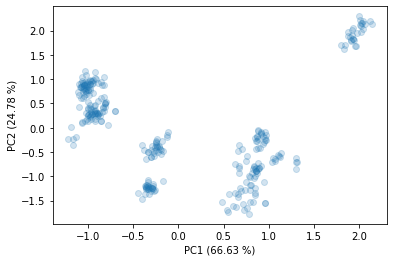

In [54]:
# Plot the first two components
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.2)
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)} %)')
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)} %)')

The first two components explain most of the variance

# Interpretation

In [56]:
# To interpret the data we first re-label the centered matrix
labeled_features = pd.DataFrame(features)
labeled_features.columns = ['mois','prot', 'fat', 'ash', 'sodium', 'carb']
labeled_features

mois      prot       fat       ash    sodium      carb
0   -1.371815  1.254181  2.749841  1.953894  2.976687 -1.227511
1   -1.301562  1.227717  2.640475  2.135338  3.030779 -1.213622
2   -1.316242  1.030010  2.851396  1.930227  2.598042 -1.225844
3   -1.085563  1.054918  2.555660  1.701449  2.543950 -1.193622
4   -1.091854  1.230830  2.390494  1.725116  2.625088 -1.172510
..        ...       ...       ...       ...       ...       ...
295  0.420144 -0.358607 -0.360411 -0.112995 -0.025423  0.138627
296  0.235600 -0.246521 -0.197477 -0.160329  0.001623  0.072514
297  0.382396 -0.367947 -0.468662 -0.160329 -0.079515  0.173072
298  0.702202 -0.458238 -0.563521 -0.247106 -0.295884  0.089181
299  0.622512 -0.539189 -0.527809 -0.286551 -0.268838  0.145294

[300 rows x 6 columns]

In [57]:
# Get the loadings matrix & extract the 'PCs'
loadings_pca = pca.transform(features)
loadings_pca.shape
# And we also get the first 2 Principal components in the appropriate shape
PC1 = pd.Series(loadings_pca[:, 0]).to_frame()
PC2 = pd.Series(loadings_pca[:, 1]).to_frame()
PC3 = pd.Series(loadings_pca[:, 2]).to_frame()

In [58]:
# We calculate the correlation between the original data and each PC
# source: https://online.stat.psu.edu/stat505/lesson/11/11.4
# If rowvar is False, each column represents a variable, while the rows contain observations
def get_correlations_feature_PC(labeled_features, PC):
    correlations = []
    for feat in labeled_features:
        feat_col = pd.Series(labeled_features.loc[:,feat]).to_frame()
        c = np.corrcoef(feat_col.to_numpy(), PC.to_numpy(), rowvar=False)[0,1]
        correlations.append(c)
    return correlations

corr = pd.DataFrame()
corr['features'] = list(labeled_features.columns)
corr['PC1'] = get_correlations_feature_PC(labeled_features, PC1)
corr['PC2'] = get_correlations_feature_PC(labeled_features, PC2)
corr['PC3'] = get_correlations_feature_PC(labeled_features, PC3)

corr

features       PC1       PC2       PC3
0     mois  0.295423 -0.897730 -0.326582
1     prot  0.829041 -0.298184  0.468610
2      fat  0.837171  0.503024 -0.097430
3      ash  0.979216  0.006291  0.048294
4   sodium  0.827157  0.478594 -0.254018
5     carb -0.937851  0.331325  0.050786

There is factorial complexity. We need a rotation to diminish it (almost all variables load on factor 1)

# Varimax rotation

In [59]:
# Source: https://stackoverflow.com/questions/17628589/perform-varimax-rotation-in-python-using-numpy
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        #if d/d_old < tol: break
    return dot(Phi, R)

loadings_pca2 = varimax(loadings_pca)


In [60]:
loadings_pca2

array([[-0.08128028,  3.0319451 , -0.32821372,  0.25970143],
       [-0.13704883,  2.98150715, -0.68952633,  0.85321306],
       [ 0.12348325,  2.92970068, -0.01639862, -0.40635046],
       ...,
       [ 0.24067485, -0.45885128, -0.74626235,  0.58773999],
       [ 0.57746621, -0.70795301, -0.61044959,  0.31572953],
       [ 0.56212623, -0.6653933 , -0.67712825,  0.22255572]])

Text(0, 0.5, 'PC2 (24.78 %)')

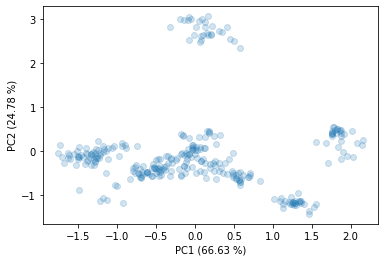

In [61]:
# Plot the first two components
plt.scatter(loadings_pca2[:, 0], loadings_pca2[:, 1], alpha=0.2)
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)} %)')
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)} %)')

In [62]:
PC1 = pd.Series(loadings_pca2[:, 0]).to_frame()
PC2 = pd.Series(loadings_pca2[:, 1]).to_frame()
PC3 = pd.Series(loadings_pca2[:, 2]).to_frame()
corr2 = pd.DataFrame()
corr2['features'] = list(labeled_features.columns)
corr2['PC1'] = get_correlations_feature_PC(labeled_features, PC1)
corr2['PC2'] = get_correlations_feature_PC(labeled_features, PC2)
corr2['PC3'] = get_correlations_feature_PC(labeled_features, PC3)

corr2

features       PC1       PC2       PC3
0     mois  0.793239 -0.434017  0.273137
1     prot  0.229300  0.419492  0.722900
2      fat  0.296623  0.949177  0.082718
3      ash  0.421755  0.701243  0.268341
4   sodium  0.350318  0.901365 -0.163763
5     carb -0.679331 -0.441392 -0.462830

Unfortunately, even after varimax rotation, PC1 and PC2 are factorially complex. Thus, we cannot directly interpret what the principal components are capturing